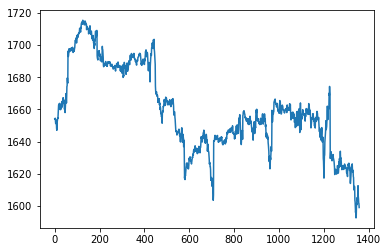

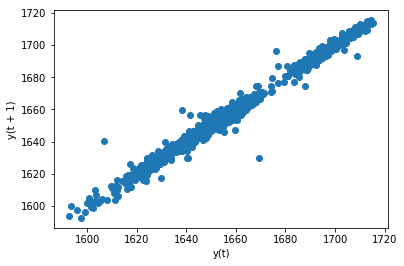

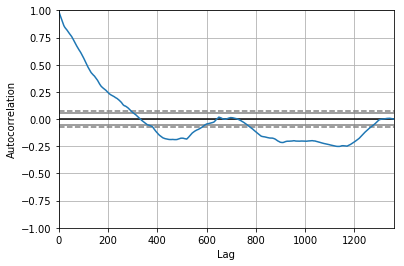

In [1]:
# https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

import pandas
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pandas_datareader import data as pdr
from pandas.plotting import lag_plot

from pandas.plotting import autocorrelation_plot

import statsmodels


df_amzn = pandas.read_excel('amzn.xlsx')

close_amzn = df_amzn['Close']


plt.plot(close_amzn)
plt.show()

lag_plot(close_amzn)
plt.show()

autocorrelation_plot(close_amzn)
plt.show()


In [159]:
len(train)

1158

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1157
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2739.852
Method:                       css-mle   S.D. of innovations              2.583
Date:                Wed, 03 Feb 2021   AIC                           5491.704
Time:                        09:33:40   BIC                           5522.025
Sample:                             1   HQIC                          5503.146
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0030      0.071     -0.043      0.966      -0.142       0.136
ar.L1.D.Close     0.6045      0.157      3.851      0.000       0.297       0.912
ar.L2.D.Close    -0.7229      0.163     

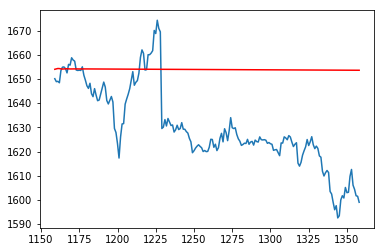

In [168]:
from statsmodels.tsa.arima_model import ARIMA as arima
from sklearn.metrics import mean_squared_error

# split dataset
X = close_amzn
train, test = X[1:len(X)-200], X[len(X)-200:]
# train autoregression
model_1 = arima(endog=train, order=(2,1,2))  
model_train_fit = model_1.fit() # stationarity
print(model_train_fit.summary())

# # make predictions
predictions = model_train_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
pred = np.nan * X
pred = np.cumsum(predictions)
# plot results
plt.plot(test)
plt.plot(pred + X[0], color='red')
plt.show()

In [139]:
del model_train

In [53]:
train.head()

1    1653.9197
2    1654.5100
3    1652.7794
4    1651.1700
5    1652.0400
Name: Close, dtype: float64

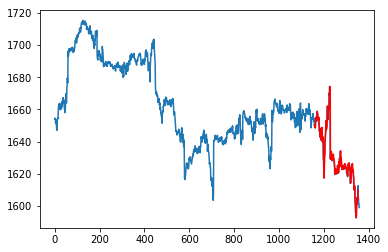

In [98]:
# # make dynamcic predictions
import pandas as pd
dyn = pd.Series(np.zeros(len(X),) * np.nan, index=X.index)
# print(dyn.loc[1251])
# # print(dyn)
# # print(model_fit.predict(start=train.index[1],end=train.index[2], exog=train[:len(train)+1], dynamic=True))
# for i,t in zip(range(3,len(test)-3), range(test.index[3],test.index[-1]-3)):
    #     print(dyn.loc[t])

    
# NOTE this takes a long time to execute
for t in range(len(X)-200,len(X)-5):
    model = arima(X[:t], order = (1,0,1))
    model_fit = model.fit()
    model_forecast = model_fit.forecast()[0]
    #     dyna = model_fit.predict(start=i, end=i+1, exog=test.loc[0:t+1], dynamic=False)
    dyn.loc[t] = model_forecast
plt.plot(X)
plt.plot(dyn, color='red')
plt.show()
# looks deceptively good. We should actually plot differences
    # print(dyn)
# print(dyna)    
#     exog=test.iloc[:1160], dynamic=True)
# dyn_predictions = 0 * predictions
# for t in range(len(train), len(train)+len(test)-1):
#     tester = model_fit.predict(start=t, end=t+2, exog=test[:t] , dynamic=False)

In [101]:
pd.concat([dyn - X.shift(), X - X.shift()], axis=1).corr()

,0,Close
0,1.000000,0.098201
Close,0.098201,1.000000


In [169]:
a = model_train_fit.params
a

const           -0.003022
ar.L1.D.Close    0.604540
ar.L2.D.Close   -0.722943
ma.L1.D.Close   -0.627048
ma.L2.D.Close    0.671755
dtype: float64

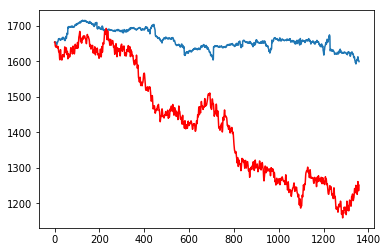

In [173]:
eps= np.random.randn(len(X)) * 2.583
dY = np.nan * X
Y = np.nan * X
dY[0] = 0.0
dY[1] = 0.0
Y[0] = X[0]
Y[1] = X[1]
for t in range(2,len(X)):     
    dY[t] = a['const'] + a['ar.L1.D.Close'] * dY[t-1]  + a['ar.L2.D.Close'] * dY[t-2] + \
         eps[t] - a['ma.L1.D.Close'] * eps[t-1] + a['ma.L2.D.Close'] * eps[t-2] 
#     Z[t] = 0.5*( a['const']   + Z[t-1]) + eps[t]  - (a['ma.L1.Close']-0.003) * eps[t-1]
    Y[t] = Y[t-1] + dY[t]
plt.plot(X)
plt.plot(Y, color='red')
plt.show()

### Notes
* We are able to simulate 'reasonable' sample paths (except AAPL doesn't go down!). 
* Care should be taken in simulating appropriate number of diffs. If (p,1,q) then you are simulating diffs, and need to cumsum.
* Care should be taken with init cond. You need as many init condns as you have p AR terms, and you need at least q eps terms to start it off
* Care should be taken in starting up the simulation.

In [194]:
len(X)
# delta = np.zeros(len(X),100)
eps= np.random.randn(len(X), 10 ) * 2.59
dYmat = 0.0 * eps
Ymat = 0.0 * eps
for sim in range(10):
    dYmat[0,sim] = 0.0
    dYmat[1, sim] = 0.0
    Ymat[0,sim] = X[0]
    Ymat[1, sim] = X[1]
    for t in range(2,len(X)):
        dYmat[t,sim] = a['const'] + a['ar.L1.D.Close'] * dYmat[t-1,sim]  + a['ar.L2.D.Close'] * dYmat[t-2,sim] + \
             eps[t,sim] - a['ma.L1.D.Close'] * eps[t-1,sim] + a['ma.L2.D.Close'] * eps[t-2,sim] 
        Ymat[t,sim] = Ymat[t-1,sim] + dYmat[t,sim]
# Y[1] = X[1]
# for t in range(2,len(X)):     
# #     Z[t] = 0.5*( a['const']   + Z[t-1]) + eps[t]  - (a['ma.L1.Close']-0.003) * eps[t-1]
#     Y[t] = Y[t-1] + dY[t]
# plt.plot(X)
# plt.plot(Y, color='red')
# plt.show()

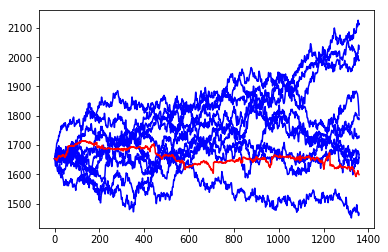

In [197]:

plt.plot(Ymat, color='blue')
plt.plot(X, color='red')
plt.show()